In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:

import report
import json
import pandas

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown

builds = report.read_file("./data/dump-2022-10-10.log")
users = pandas.read_json("./data/userinfo.json")

def mdprint(msg):
    display(Markdown(msg))

mdprint(f"Read {len(builds)} records")

# remove builds before Image builder GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-10-10.pkl


Read 6154 records

Using 4320 records (since GA)

In [3]:
users = pandas.read_json("./data/userinfo.json")
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 1814 records (after filtering)

In [4]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-10-09 20:01:24.750877

- Total builds: 1814
- Number of users: 698
- Builds with packages: 1042
- Builds with filesystem customizations: 634
- Builds with custom repos: 22

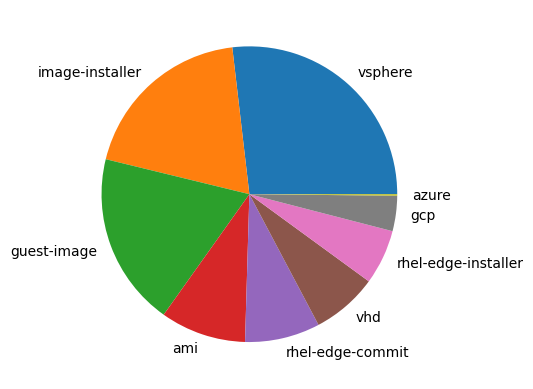

In [5]:
ib.plot.imagetype_builds(builds)

In [6]:
# separate builds for "edge" types
edge_idxs = builds["image_type"].str.contains("edge")
edge_builds = builds.loc[edge_idxs]
non_edge_builds = builds.loc[-edge_idxs]

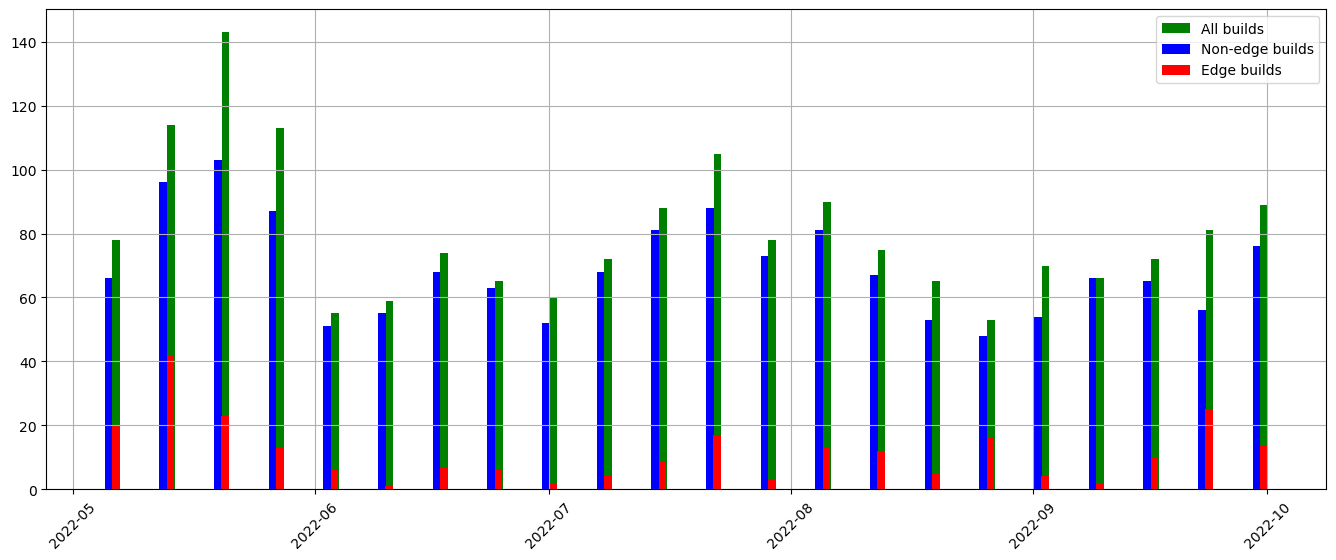

In [7]:
# builds per 7-day period for edge vs non-edge
plt.figure()
ax = plt.axes([0, 0, 2, 1])
p_days = timedelta(days=7)
bar_shift = timedelta(days=1)
e_starts, eb = ib.metrics.builds_over_time(edge_builds, p_days)
b_starts, bb = ib.metrics.builds_over_time(builds, p_days)
ne_starts, ne = ib.metrics.builds_over_time(non_edge_builds, p_days)
ax.bar(b_starts+bar_shift*2, bb, color="green", width=1, label="All builds")
ax.bar(ne_starts+bar_shift, ne, color="blue", width=1, label="Non-edge builds")
ax.bar(e_starts, eb, color="red", width=1, label="Edge builds")

# rotate xtick labels 45 degrees cw for readability
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.legend()
ax.grid(True)

## Users building **edge** vs **non-edge** per week.
- Users are counted based on the image type they build at any given time.
- A user that builds both an edge and non-edge type is counted in **both** categories.

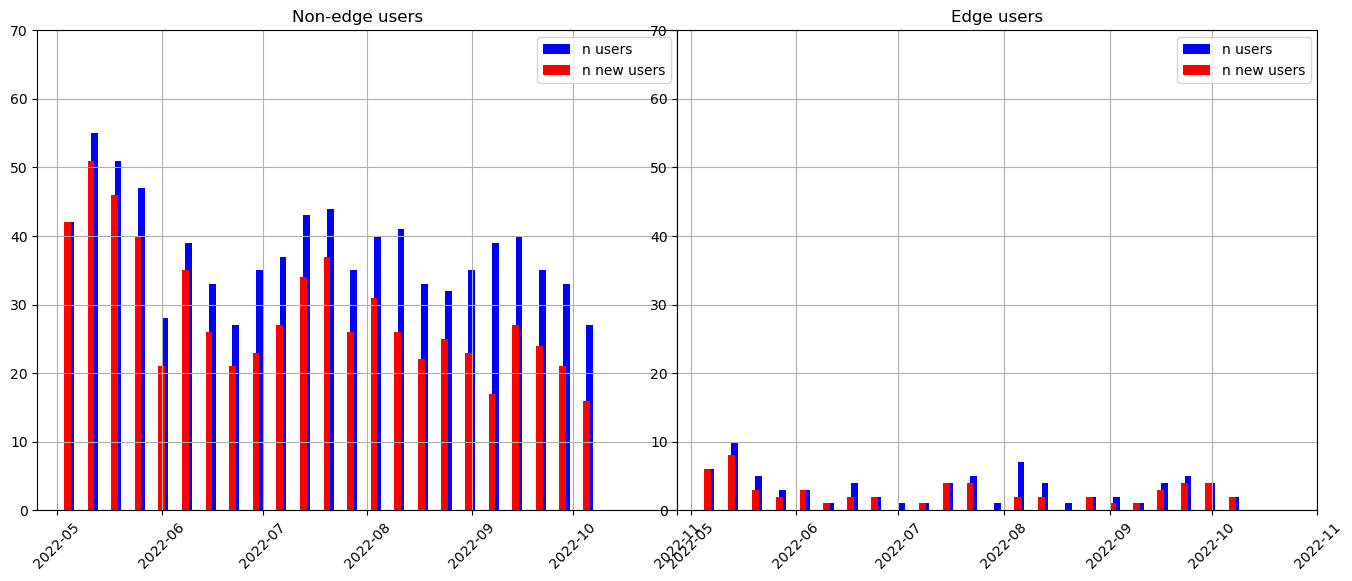

In [8]:
# Users building edge vs non-edge per week
# Users are counted based on the image type they build at any given time
# A user  that builds both an edge and non-edge type is counted in both categories
fig = plt.figure()

ymax = 70
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.weekly_users(non_edge_builds, ax1)
ax1.set_ylim(ymin=0, ymax=ymax)
ax1.set_title("Non-edge users")

ax2 = fig.add_axes([1, 0, 1, 1])
ib.plot.weekly_users(edge_builds, ax2)
ax2.set_ylim(ymin=0, ymax=ymax)
ax2.set_title("Edge users")
mdprint("## Users building **edge** vs **non-edge** per week.\n"
"- Users are counted based on the image type they build at any given time.\n"
"- A user that builds both an edge and non-edge type is counted in **both** categories.")

In [9]:
# Separate *users* based on edge vs non-edge
# If any user builds at least one edge image, put all their builds in the edge bucket
edge_users = edge_builds["org_id"].unique()
all_users = builds["org_id"].unique()
non_edge_users = np.setdiff1d(all_users, edge_users)
print(f"Number of edge users*:    {len(edge_users):4d}")
print(f"Number of non-edge users: {len(non_edge_users):4d}")
print(f"Total users:              {len(all_users):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_users) + len(non_edge_users) == len(all_users)

Number of edge users*:      57
Number of non-edge users:  641
Total users:               698
(* "edge user" is any user that has ever built at least a single edge image)


In [10]:
# Separate builds based on edge-tagged users
edge_user_builds_idxs = builds["org_id"].isin(edge_users)
edge_user_builds = builds.loc[edge_user_builds_idxs]
non_edge_user_builds_idxs = builds["org_id"].isin(non_edge_users)
non_edge_user_builds = builds.loc[non_edge_user_builds_idxs]

print(f"Number of builds from edge users*:    {len(edge_user_builds):4d}")
print(f"Number of builds from non-edge users: {len(non_edge_user_builds):4d}")
print(f"Total builds:                         {len(builds):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_user_builds) + len(non_edge_user_builds) == len(builds)

Number of builds from edge users*:     334
Number of builds from non-edge users: 1480
Total builds:                         1814
(* "edge user" is any user that has ever built at least a single edge image)


## Edge vs non-edge users per week
- Users are counted as edge if they ever built at least one edge image

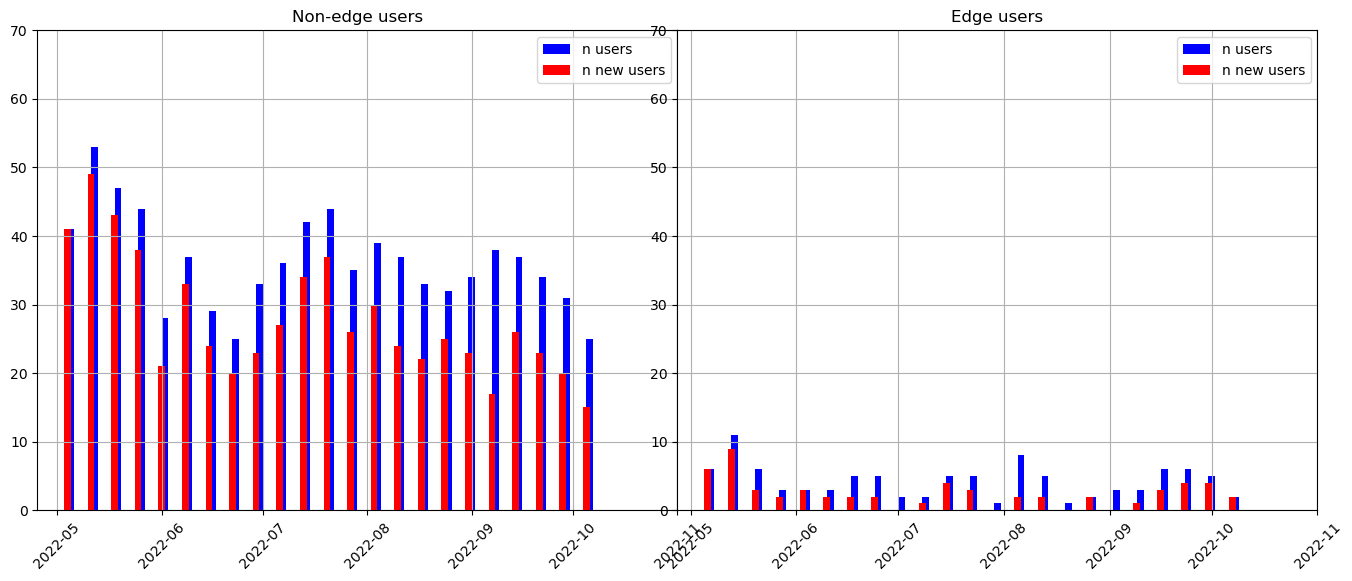

In [11]:
# Users from edge vs non-edge users
fig = plt.figure()
ymax = 70
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.weekly_users(non_edge_user_builds, ax1)
ax1.set_ylim(ymin=0, ymax=ymax)
ax1.set_title("Non-edge users")

ax2 = fig.add_axes([1, 0, 1, 1])
ib.plot.weekly_users(edge_user_builds, ax2)
ax2.set_ylim(ymin=0, ymax=ymax)
ax2.set_title("Edge users")

mdprint("## Edge vs non-edge users per week\n"
"- Users are counted as edge if they ever built at least one edge image")

## Builds from edge vs non-edge users per week
- Users are counted as edge if they ever built at least one edge image.
- Builds from an **edge user** are counted in **Edge user builds** regardless of the type.

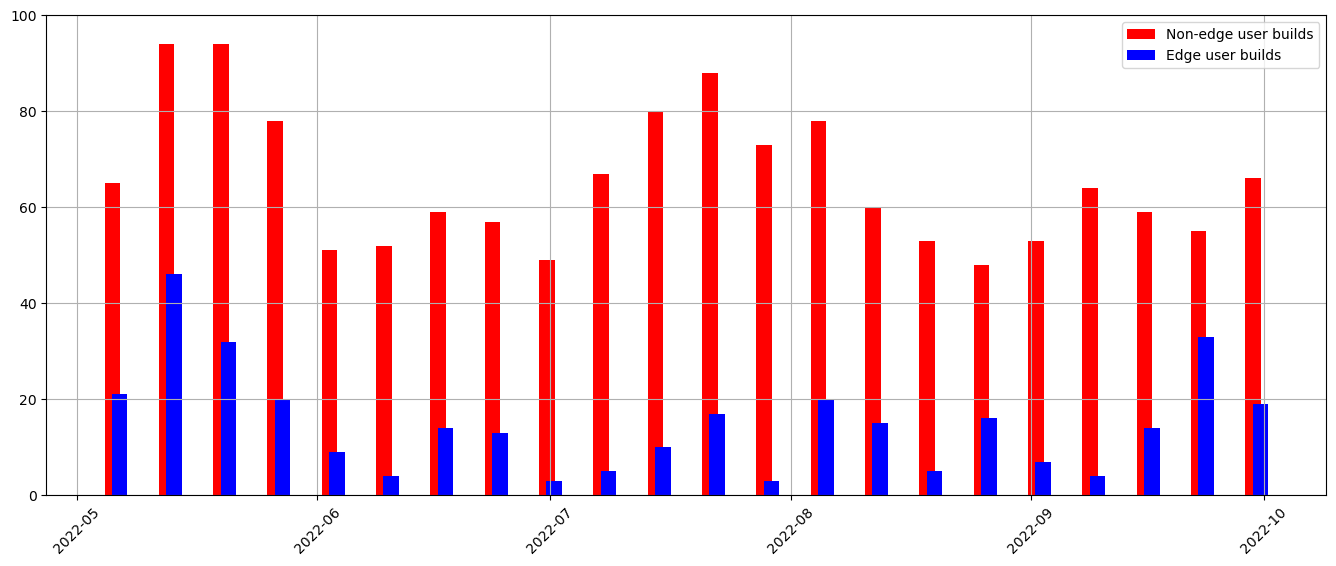

In [12]:
# builds from edge vs non-edge users
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])
ymax = 100
t_starts, non_edge_build_counts = ib.metrics.builds_over_time(non_edge_user_builds, period=timedelta(days=7))
ax.bar(t_starts+bar_shift, non_edge_build_counts, color="red", width=2, label="Non-edge user builds")

t_starts, edge_build_counts = ib.metrics.builds_over_time(edge_user_builds, period=timedelta(days=7))
ax.bar(t_starts, edge_build_counts, color="blue", width=2, label="Edge user builds")
ax.legend()
ax.set_ylim(ymax=ymax)
# rotate xtick labels 45 degrees cw for readability
for label in ax.get_xticklabels():
    label.set_rotation(45)

plt.grid(True)
mdprint("## Builds from edge vs non-edge users per week\n"
    "- Users are counted as edge if they ever built at least one edge image.\n"
    "- Builds from an **edge user** are counted in **Edge user builds** regardless of the type.")